In [1]:
import qspectra as qs
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
ham = qs.ElectronicHamiltonian(np.array([[12881, 120], [120, 12719]]),
                               bath=qs.DebyeBath(qs.CM_K * 77, 35, 106),
                               dipoles=[[1, 0, 0], [2 * np.cos(.3), 2 * np.sin(.3), 0]])

red_dimer = qs.RedfieldModel(ham, hilbert_subspace='gef', discard_imag_corr=True, unit_convert=qs.CM_FS)
heom_dimer = qs.HEOMModel(ham, hilbert_subspace='gef', unit_convert=qs.CM_FS, level_cutoff=3, low_temp_corr=False)


In [4]:
Omega = [-500., -200., -90., 1., 21., 60., 80., 130., 200., 300., 400., 500., 600., 800., 1100., 1500.] # frequencies of PMs
huang = [-2.5133e-03, -7.5398e-03, -2.5133e-02, 5.0265e+01, 2.2619e+00, 4.5239e-02, 2.7646e-01,
          9.2991e-03, 2.2619e-02, 1.5080e-02, 3.0159e-03, 
          3.5186e-03, 2.8274e-04, 1.7593e-03, 4.3982e-04, 4.3982e-04] # Huang-Rhys factors of PMs (couplings to PMs)
gamma = [500., 100., 50., 50., 50., 50., 80., 40., 80., 150., 200., 200., 80., 250., 200., 300.] # dampings of the PMs

n_sites = ham.n_sites
numb_pm = len(Omega)
on = np.ones(n_sites, complex)

Omega = np.array([Omega[pm]*on for pm in range(numb_pm)])
huang = np.array([huang[pm]*on for pm in range(numb_pm)])
gamma = np.array([gamma[pm]*on for pm in range(numb_pm)])

zofe_ham = qs.ElectronicHamiltonian(
    ham.H('e'), bath=qs.PseudomodeBath(numb_pm, Omega, gamma, huang), 
    dipoles=ham.dipoles)
zofe_dimer = qs.ZOFEModel(zofe_ham, hilbert_subspace='ge', unit_convert=qs.CM_FS)


## Absorption spectra

In [39]:
f, X = qs.absorption_spectra(heom_dimer, 10000)
f2, X2 = qs.absorption_spectra(red_dimer, 10000)
f3, X3 = qs.absorption_spectra(zofe_dimer, 10000)

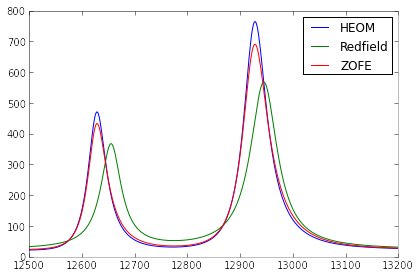

In [40]:
plt.plot(f, X, label='HEOM')
plt.plot(f2, X2, label='Redfield')
plt.plot(f3, X3, label='ZOFE')
plt.xlim(12500, 13200)
plt.legend()

## 2D spectra

In [32]:
%%time
(f1, t2, f3), X = qs.two_dimensional_spectra(red_dimer, coherence_time_max=1000,
                                             population_times=np.linspace(0, 1000, 50),
                                             geometry='-++', polarization='xxxx',
                                             include_signal='GSB,ESE,ESA')

CPU times: user 804 ms, sys: 56.7 ms, total: 860 ms
Wall time: 858 ms


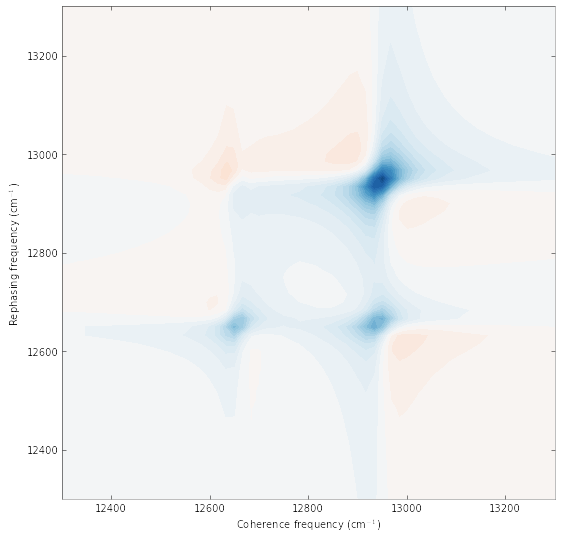

In [33]:
plt.figure(figsize=(8, 8))
plt.contourf(f1, f3, X[:,5,:].real, 30, cmap='RdBu', vmax=6e5, vmin=-6e5)
plt.xlabel('Coherence frequency (cm$^{-1}$)')
plt.ylabel('Rephasing frequency (cm$^{-1}$)')
plt.xlim(12300, 13300)
plt.ylim(12300, 13300);


In [34]:
%%time
(f1, t2, f3), X = qs.two_dimensional_spectra(heom_dimer, coherence_time_max=1000,
                                             population_times=np.linspace(0, 1000, 50),
                                             geometry='-++', polarization='xxxx',
                                             include_signal='GSB,ESE,ESA')

CPU times: user 4.85 s, sys: 66.7 ms, total: 4.91 s
Wall time: 4.91 s


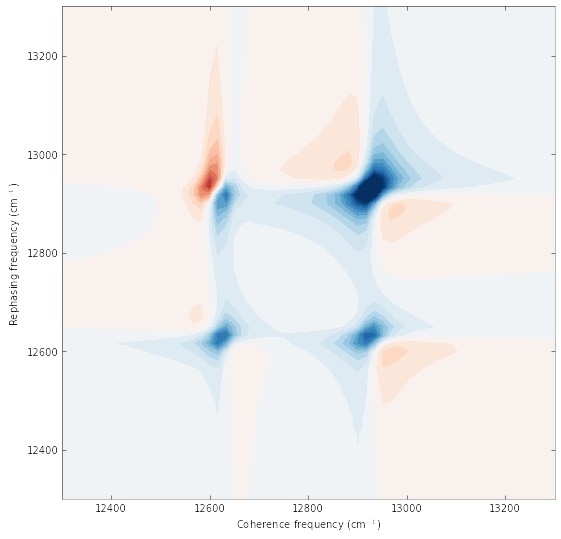

In [38]:
plt.figure(figsize=(8, 8))
plt.contourf(f1, f3, X[:,5,:].real, 30, cmap='RdBu', vmax=6e5, vmin=-6e5)
plt.xlabel('Coherence frequency (cm$^{-1}$)')
plt.ylabel('Rephasing frequency (cm$^{-1}$)')
plt.xlim(12300, 13300)
plt.ylim(12300, 13300);
